# Machine Learning Models

## Setup

In [15]:
# pip installs

In [157]:
from tqdm import tqdm
import pandas as pd
import humanize
from datetime import datetime, timedelta
import time
import numpy as np
import seaborn as sns
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("training_data.csv")
df = df.drop(columns=df.columns[0])
df.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
0,5475,0.050966,0.303030,1.0,0.241645,0.051458,0.833333,0.074582,0.046235,1.0
1,9737,0.128999,0.151515,1.0,0.305913,0.144583,0.750000,0.100625,0.293084,1.0
2,501,0.044546,0.363636,1.0,0.768638,0.051458,0.791667,0.005656,0.011231,1.0
3,4325,0.055708,0.303030,1.0,0.426735,0.083333,0.916667,0.099840,0.131749,1.0
4,9008,0.170005,0.454545,1.0,1.000000,0.144583,0.833333,0.171107,0.061357,1.0


Now let's try to make some models and see what we can do!

In [3]:
y = df["runtime"]

X = df.drop(columns=["runtime"])

In [4]:
TEST_RATIO = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO,random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(len(X_train), len(X_test), len(y_train), len(y_test))

1096 471 1096 471


In [5]:
def print_score(y_true, y_pred):
    print("Mean Squared Error:".ljust(22," "),round(mean_squared_error(y_true, y_pred)))
    print("Mean Absolute Error:".ljust(22," "), round(mean_absolute_error(y_true, y_pred)))

In [226]:

def convert(seconds):
    return humanize.naturaldelta(timedelta(seconds=seconds))

def show_diff(predictions,y_test,n=25):
    print("PREDICTION\t RESULT\t\t DIFFERENCE")
    print("-"*45)
    for i in range(0,n):
        print(convert(predictions[i]), "\t",convert(int(y_test[i])), "\t", convert(y_test[i] - predictions[i]))

def show_plots(predictions, y_test, s=4):
    plt.subplot(211)
    plt.title("Test Results and Predictions")
    plt.scatter(range(len(y_test)),y_test,s=s)
    plt.xlabel("X_test[i]")
    plt.ylabel("correct answer")
    plt.subplot(212)
    plt.scatter(range(len(predictions)),predictions,s=s)
    plt.ylabel("predictions")
    plt.show()

# K Means Clustering

In [244]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split

In [245]:
# ------ experiment with cluster amount ---------- #
n_clusters = 10
# ------ experiment with cluster amount ---------- #

model = KMeans(n_clusters=n_clusters, n_init=10)
model = model.fit(X_train,y_train)

In [246]:
prediction = model.predict(X_test)

In [247]:
prediction_mapping = (prediction / n_clusters) * y_test.max()
results = pd.DataFrame( {
    "prediction": prediction_mapping,
    "answer":y_test,
    "difference": y_test-prediction_mapping
} )
results

,prediction,answer,difference
0,32332.8,1567,-30765.8
1,5388.8,11449,6060.2
2,32332.8,2287,-30045.8
3,21555.2,592,-20963.2
4,26944.0,14158,-12786.0
...,...,...,...
466,32332.8,23802,-8530.8
467,21555.2,10,-21545.2
468,43110.4,10407,-32703.4
469,32332.8,1375,-30957.8


In [248]:
print_score(results["answer"], results["prediction"])

Mean Squared Error:    600622948
Mean Absolute Error:   21806


### Now let's try for many values of k

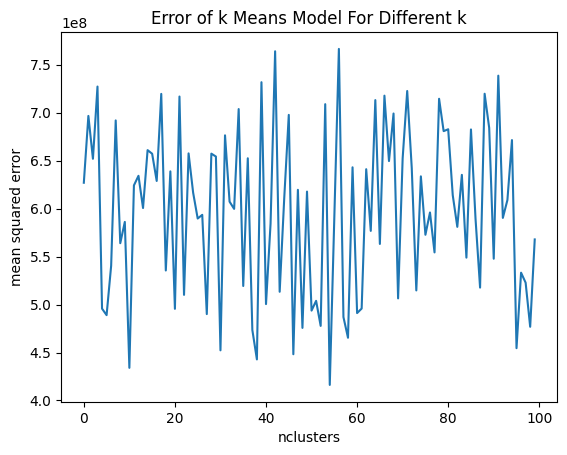

In [249]:
def get_mse(n_clusters):
    global X_test, y_test, X_train, y_train
    n_clusters = 30
    model = KMeans(n_clusters=n_clusters, n_init='auto')
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    
    prediction_mapping = (prediction / n_clusters) * y_test.max()
    return mean_squared_error(y_true=y_test, y_pred=prediction_mapping)

get_mse(30)
clusters = list(range(0,100))
MSE = []
for i in clusters:
    MSE.append(round(get_mse(i),2))

plt.title("Error of k Means Model For Different k")
plt.xlabel("nclusters")
plt.ylabel("mean squared error")
plt.plot(clusters,MSE)
plt.show()

so it looks like K means clustering has a long way to go and more clusters has no real effect on the accuracy. Let's try some other methods

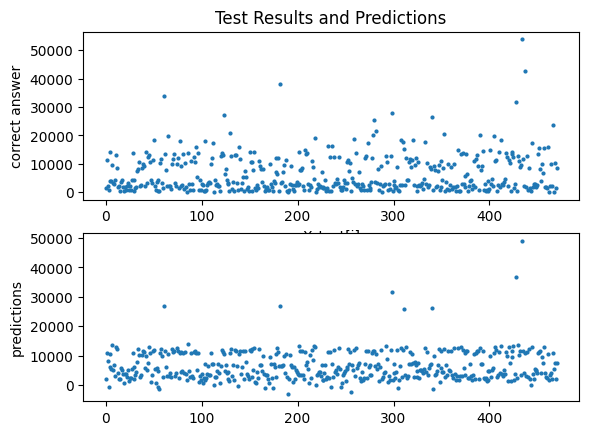

In [250]:
show_plots(predictions,y_test)

# Multi Linear Regression

In [238]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [239]:
model = LinearRegression()
model = model.fit(X_train,y_train)

In [240]:
predictions = model.predict(X_test)
print_score(predictions,y_test)

Mean Squared Error:    12635260
Mean Absolute Error:   2365


In [251]:
show_diff(predictions,y_test,n=10)

PREDICTION	 RESULT		 DIFFERENCE
---------------------------------------------
33 minutes 	 26 minutes 	 a day
3 hours 	 3 hours 	 8 minutes
2 hours 	 38 minutes 	 a day
a day 	 9 minutes 	 19 minutes
2 hours 	 3 hours 	 an hour
an hour 	 an hour 	 a day
an hour 	 an hour 	 a day
3 hours 	 2 hours 	 a day
an hour 	 51 minutes 	 a day
an hour 	 45 minutes 	 a day


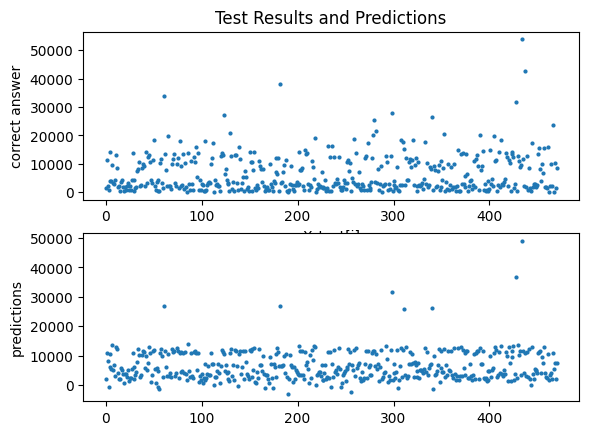

In [255]:
show_plots(predictions,y_test,s=4)

In [45]:
print(len(X_test))

471


# Neural Net

In [47]:
def normalize(series):
    return MinMaxScaler().fit_transform(np.array(series).reshape(-1,1))

y_train = normalize(y_train)

In [48]:
# example of training a final regression model
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler

# generate regression dataset
X, y = make_regression(n_samples=100, n_features=2, noise=0.1, random_state=1)
scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
scalarX.fit(X)
scalarY.fit(y.reshape(100,1))
X = scalarX.transform(X)
y = scalarY.transform(y.reshape(100,1))

# define and fit the final model
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=100, verbose=0)
model.predict(X[:4])

1/1 [==============================] - 0s 35ms/step


array([[0.6039424 ],
       [0.29471874],
       [0.28626117],
       [0.36821702]], dtype=float32)

In [49]:
y[:4]

array([[0.60338436],
       [0.29378732],
       [0.28669777],
       [0.36711231]])

In [50]:
predictions = model.predict(X[:4], verbose=0)
print_score(predictions, y[:4])

# Mean Squared Error:    0.03558335327632717
# Mean Absolute Error:   0.16927700703786802

Mean Squared Error:    0
Mean Absolute Error:   0


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(9,)),
    tf.keras.layers.Dense(9, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),

    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(
    optimizer="adam",
    loss="mse",
)

In [7]:
model.fit(x=X_train, y=y_train, epochs=100, verbose=0)

In [264]:
predictions = model.predict(X_test, verbose=0)
predictions[:3]

array([[0.01552695],
       [0.21284617],
       [0.10425124]], dtype=float32)

In [265]:
predictions-y_test

array([[ -1566.98447305, -11448.98447305,  -2286.98447305, ...,
        -10406.98447305,  -1374.98447305,  -8532.98447305],
       [ -1566.78715383, -11448.78715383,  -2286.78715383, ...,
        -10406.78715383,  -1374.78715383,  -8532.78715383],
       [ -1566.89574876, -11448.89574876,  -2286.89574876, ...,
        -10406.89574876,  -1374.89574876,  -8532.89574876],
       ...,
       [ -1566.84989271, -11448.84989271,  -2286.84989271, ...,
        -10406.84989271,  -1374.84989271,  -8532.84989271],
       [ -1566.96653913, -11448.96653913,  -2286.96653913, ...,
        -10406.96653913,  -1374.96653913,  -8532.96653913],
       [ -1566.7999973 , -11448.7999973 ,  -2286.7999973 , ...,
        -10406.7999973 ,  -1374.7999973 ,  -8532.7999973 ]])

In [266]:
def print_score(y_true, y_pred):
    print("Mean Squared Error:".ljust(22," "),mean_squared_error(y_true, y_pred))
    print("Mean Absolute Error:".ljust(22," "), mean_absolute_error(y_true, y_pred))
print_score(predictions, y_test)

Mean Squared Error:    86507325.40580958
Mean Absolute Error:   6431.928245299413


In [261]:

Mean Squared Error:    86506857.70903887
Mean Absolute Error:   6431.912279610207

Mean Squared Error:    86506687.77386706
Mean Absolute Error:   6431.89729009321

Mean Squared Error:    86506881.56282507
Mean Absolute Error:   6431.909780053204

Mean Squared Error:    86506690.3881022
Mean Absolute Error:   6431.898311441057

Mean Squared Error:    86506774.30611314
Mean Absolute Error:   6431.903274915572


# SVM

In [234]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
model = SVR(kernel='rbf')
model = model.fit(X_train,y_train)

In [235]:
predictions = model.predict(X_test)
print_score(predictions,y_test)

Mean Squared Error:    56633833
Mean Absolute Error:   4789


In [236]:
show_diff(predictions,y_test)

PREDICTION	 RESULT		 DIFFERENCE
---------------------------------------------
50 minutes 	 26 minutes 	 a day
50 minutes 	 3 hours 	 2 hours
50 minutes 	 38 minutes 	 a day
49 minutes 	 9 minutes 	 a day
50 minutes 	 3 hours 	 3 hours
50 minutes 	 an hour 	 15 minutes
50 minutes 	 an hour 	 17 minutes
50 minutes 	 2 hours 	 an hour
50 minutes 	 51 minutes 	 a minute
50 minutes 	 45 minutes 	 a day
49 minutes 	 an hour 	 20 minutes
50 minutes 	 3 hours 	 2 hours
50 minutes 	 2 hours 	 an hour
50 minutes 	 27 minutes 	 a day
49 minutes 	 35 minutes 	 a day
50 minutes 	 8 minutes 	 a day
50 minutes 	 56 minutes 	 6 minutes
50 minutes 	 an hour 	 19 minutes
50 minutes 	 32 minutes 	 a day
50 minutes 	 8 minutes 	 a day
50 minutes 	 30 minutes 	 a day
50 minutes 	 13 minutes 	 a day
50 minutes 	 33 minutes 	 a day
50 minutes 	 54 minutes 	 4 minutes
50 minutes 	 12 minutes 	 a day


seems like this only predicts something like the best guess of the dataset, not actually doing much prediction

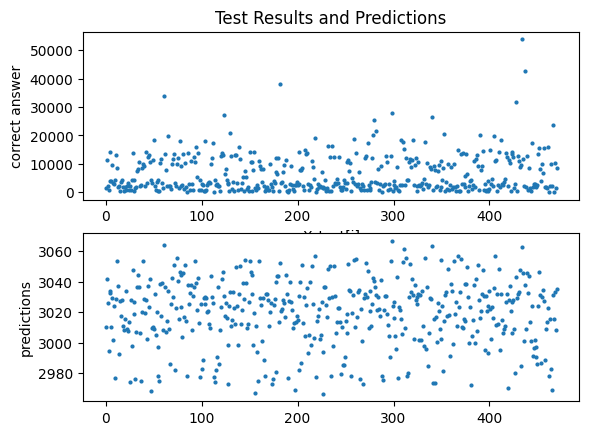

In [237]:
show_plots(predictions,y_test)

# Decision Trees

In [139]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model = model.fit(X_train, y_train)

In [140]:
predictions = model.predict(X_test)
print_score(predictions,y_test)

Mean Squared Error:    15790785
Mean Absolute Error:   1997


In [228]:
show_diff(predictions,y_test)

PREDICTION	 RESULT		 DIFFERENCE
---------------------------------------------
33 minutes 	 26 minutes 	 a day
3 hours 	 3 hours 	 8 minutes
2 hours 	 38 minutes 	 a day
a day 	 9 minutes 	 19 minutes
2 hours 	 3 hours 	 an hour
an hour 	 an hour 	 a day
an hour 	 an hour 	 a day
3 hours 	 2 hours 	 a day
an hour 	 51 minutes 	 a day
an hour 	 45 minutes 	 a day
50 minutes 	 an hour 	 19 minutes
3 hours 	 3 hours 	 3 minutes
3 hours 	 2 hours 	 a day
an hour 	 27 minutes 	 a day
34 minutes 	 35 minutes 	 a minute
35 minutes 	 8 minutes 	 a day
an hour 	 56 minutes 	 a day
an hour 	 an hour 	 a day
59 minutes 	 32 minutes 	 a day
9 minutes 	 8 minutes 	 a day
an hour 	 30 minutes 	 a day
an hour 	 13 minutes 	 a day
48 minutes 	 33 minutes 	 a day
an hour 	 54 minutes 	 a day
20 minutes 	 12 minutes 	 a day


In [156]:
# predictions.std()

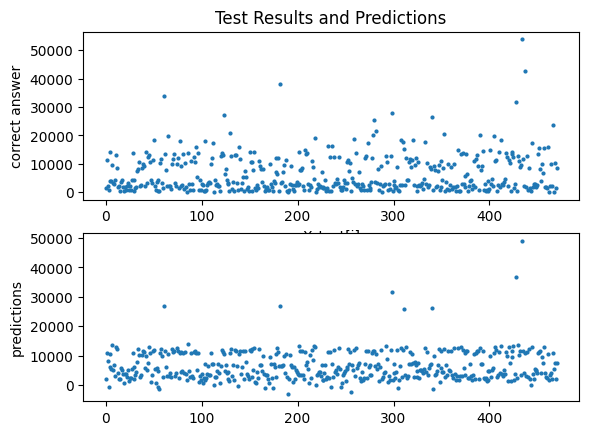

In [227]:
show_plots(predictions,y_test)

# Next method